In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [3]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [4]:
sheet = pd.read_excel('data_input/氧化铝周度表需trend.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
sheet = sheet.reset_index().rename(columns={'index': 'Date'})

In [5]:
sheet

,Date,氧化铝周度表需/4WMA,氧化铝周度表需/4WMATrend/F0.2
0,2021-12-10,137.437,133.012089
1,2021-12-17,137.437,133.322940
2,2021-12-24,137.437,133.647002
3,2021-12-31,137.402,133.984558
4,2022-01-07,137.367,134.335538
...,...,...,...
194,2025-10-10,181.900,180.951016
195,2025-10-17,181.525,181.542168
196,2025-10-24,181.525,182.131937
197,2025-10-31,181.100,182.719682


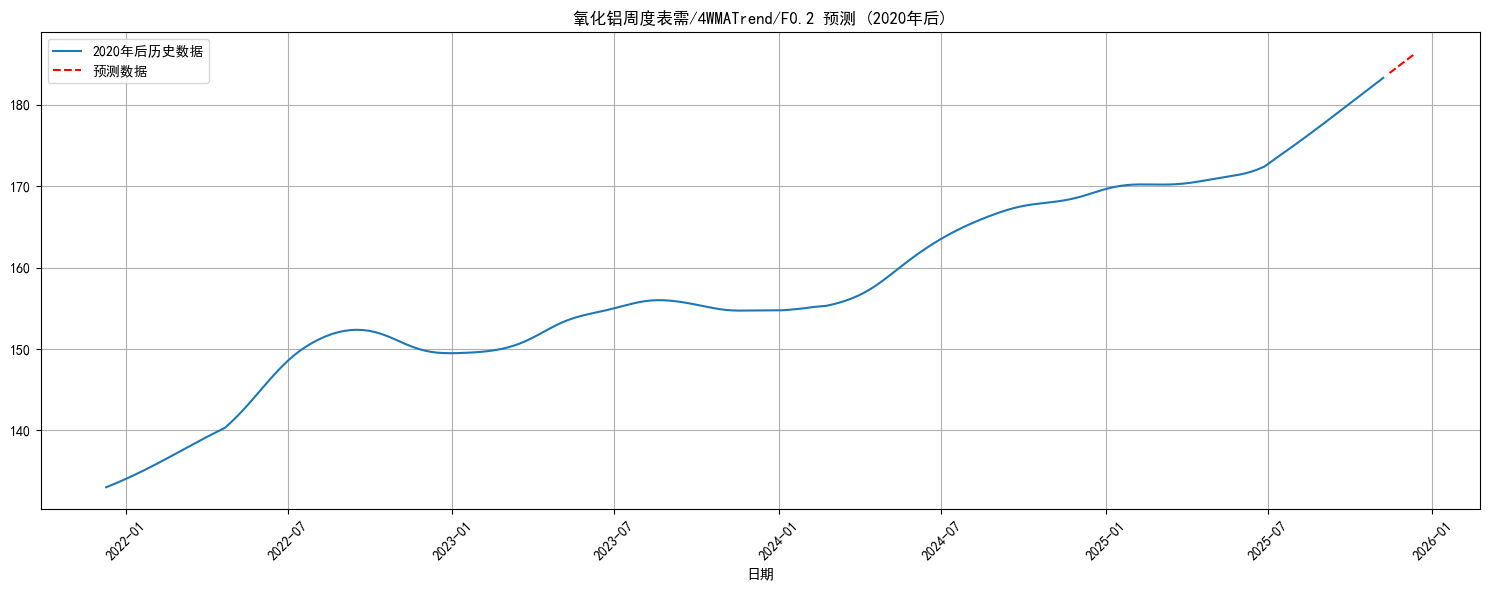

In [6]:
sheet.dropna()
# 获取最后一个日期
last_date = pd.to_datetime(sheet['Date'].iloc[-1])

# 生成未来30个工作日
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=5, freq='W-FRI')  # 生成45天以确保获得30个工作日
future_dates = future_dates[future_dates.dayofweek < 5][:5]  # 只保留工作日并取前30天

# 获取最后30个历史值用于线性回归
last_values = sheet['氧化铝周度表需/4WMATrend/F0.2'].tail(5).values
x = np.arange(len(last_values))
y = last_values

# 进行线性回归
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

# 预测未来30个值
future_x = np.arange(len(last_values), len(last_values) + 5)
future_values = p(future_x)

# 创建预测数据框
future_df = pd.DataFrame({
    'Date': future_dates,
    '氧化铝周度表需/4WMATrend/F0.2': future_values
})

# 合并历史数据和预测数据
sheet_with_predictions = pd.concat([sheet, future_df], ignore_index=True)
# 筛选2020年之后的数据
sheet_2020 = sheet[sheet['Date'] >= '2020-01-01']

# 绘制结果
plt.figure(figsize=(15, 6))
plt.plot(sheet_2020['Date'], sheet_2020['氧化铝周度表需/4WMATrend/F0.2'], label='2020年后历史数据')
plt.plot(future_df['Date'], future_df['氧化铝周度表需/4WMATrend/F0.2'], 'r--', label='预测数据')
plt.title('氧化铝周度表需/4WMATrend/F0.2 预测 (2020年后)')
plt.xlabel('日期')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [7]:
########################   读取数据  #########################################
sheet_non_trend = pd.read_excel('eta/氧化铝周度表需Non-Trend_F0.2_合并数据.xlsx', sheet_name='Sheet1')
sheet_non_trend['Date'] = pd.to_datetime(sheet_non_trend['Date'])
# trend + non-trend 
merged_df = pd.merge(
    sheet_non_trend[['Date', '预测值']], 
    future_df[['Date', '氧化铝周度表需/4WMATrend/F0.2']], 
    on='Date',
    how='outer'
)
# 删除包含空值的行
merged_df = merged_df.dropna()
# 计算最终的
merged_df['氧化铝周度表需/4WMA'] = merged_df['预测值'] + merged_df['氧化铝周度表需/4WMATrend/F0.2']
merged_df.head() 

,Date,预测值,氧化铝周度表需/4WMATrend/F0.2,氧化铝周度表需/4WMA
143,2025-11-14,-2.9,183.895524,180.995524
144,2025-11-21,-2.8,184.484052,181.684052
145,2025-11-28,-2.5,185.072580,182.572580
146,2025-12-05,-2.5,185.661108,183.161108
147,2025-12-12,-2.5,186.249636,183.749636


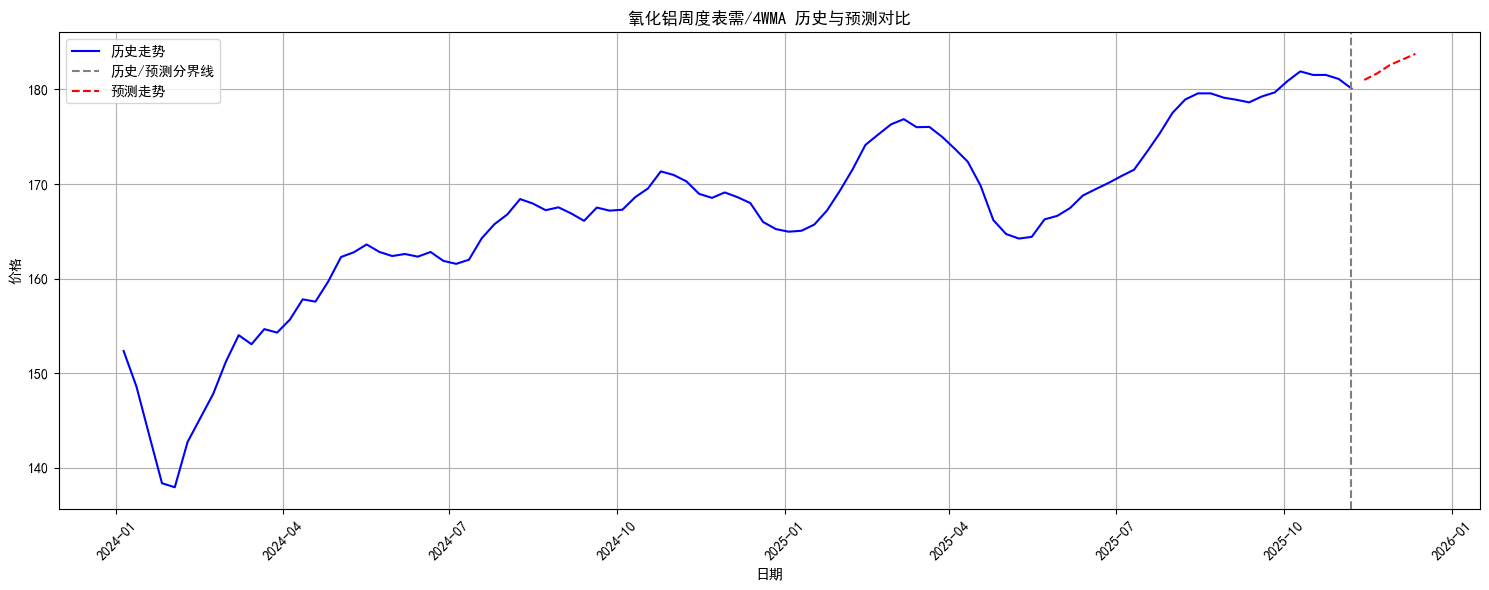

In [8]:
# 绘制最终走势图
plt.figure(figsize=(15, 6))
# 筛选2020年之后的数据
sheet_2020 = sheet[sheet['Date'] >= '2024-01-01']
# 绘制历史数据
plt.plot(sheet_2020['Date'], sheet_2020['氧化铝周度表需/4WMA'], label='历史走势', color='blue')
# 添加垂直分隔线,标记历史数据和预测数据的分界点
last_historical_date = sheet_2020['Date'].iloc[-1]
plt.axvline(x=last_historical_date, color='gray', linestyle='--', label='历史/预测分界线')
# 绘制预测数据
plt.plot(merged_df['Date'], merged_df['氧化铝周度表需/4WMA'], label='预测走势', color='red', linestyle='--')

plt.title('氧化铝周度表需/4WMA 历史与预测对比')
plt.xlabel('日期')
plt.ylabel('价格')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [9]:
sheet_data_2023_shizhi = sheet[sheet['Date'].dt.year >= 2023][['Date', '氧化铝周度表需/4WMA']]
sheet_data_2023_shizhi.columns = ['Date', '实际值']
future_df_shizhi = merged_df[['Date', '氧化铝周度表需/4WMA']]
merged_df_shizhi = pd.merge(sheet_data_2023_shizhi, future_df_shizhi, on='Date', how='outer')
merged_df_shizhi = merged_df_shizhi.sort_values('Date', ascending=False)
merged_df_shizhi['Date'] = merged_df_shizhi['Date'].dt.strftime('%Y/%m/%d')
merged_df_shizhi.to_excel('eta/氧化铝周度表需_合并数据.xlsx', index=False,float_format='%.2f')
merged_df_shizhi

,Date,实际值,氧化铝周度表需/4WMA
147,2025/12/12,NaN,183.749636
146,2025/12/05,NaN,183.161108
145,2025/11/28,NaN,182.572580
144,2025/11/21,NaN,181.684052
143,2025/11/14,NaN,180.995524
...,...,...,...
4,2023/02/03,142.5950,NaN
3,2023/01/27,143.1474,NaN
2,2023/01/20,143.5285,NaN
1,2023/01/13,143.2097,NaN


In [10]:
# 将日期列转换为datetime格式
merged_df_shizhi['Date'] = pd.to_datetime(merged_df_shizhi['Date'])
# 按月份重采样并取每月最后一个交易日的数据
monthly_df_shizhi = merged_df_shizhi.set_index('Date').resample('ME').last()
monthly_df_shizhi = monthly_df_shizhi.sort_values('Date', ascending=False)
# 重置索引并格式化日期
monthly_df_shizhi = monthly_df_shizhi.reset_index()
monthly_df_shizhi['Date'] = monthly_df_shizhi['Date'].dt.strftime('%Y/%m/%d')
# 保存月度数据到Excel
monthly_df_shizhi.to_excel('eta/氧化铝周度表需_月度数据.xlsx', index=False, float_format='%.2f')
monthly_df_shizhi.head()

,Date,实际值,氧化铝周度表需/4WMA
0,2025/12/31,NaN,183.749636
1,2025/11/30,180.100,182.572580
2,2025/10/31,181.100,NaN
3,2025/09/30,179.675,NaN
4,2025/08/31,179.125,NaN


In [11]:
sheet_data_2023 = sheet[sheet['Date'].dt.year >= 2023][['Date', '氧化铝周度表需/4WMATrend/F0.2']]
sheet_data_2023.columns = ['Date', '实际值']
merged_df_trend = pd.merge(sheet_data_2023, future_df, on='Date', how='outer')
merged_df_trend = merged_df_trend.sort_values('Date', ascending=False)
merged_df_trend['Date'] = merged_df_trend['Date'].dt.strftime('%Y/%m/%d')
merged_df_trend.to_excel('eta/氧化铝周度表需Trend-F0.2_合并数据.xlsx', index=False,float_format='%.2f')
merged_df_trend

,Date,实际值,氧化铝周度表需/4WMATrend/F0.2
147,2025/12/12,NaN,186.249636
146,2025/12/05,NaN,185.661108
145,2025/11/28,NaN,185.072580
144,2025/11/21,NaN,184.484052
143,2025/11/14,NaN,183.895524
...,...,...,...
4,2023/02/03,149.656246,NaN
3,2023/01/27,149.595317,NaN
2,2023/01/20,149.548836,NaN
1,2023/01/13,149.513898,NaN


In [12]:
# 将日期列转换为datetime格式
merged_df_trend['Date'] = pd.to_datetime(merged_df_trend['Date'])
# 按月份重采样并取每月最后一个交易日的数据
monthly_df_trend = merged_df_trend.set_index('Date').resample('ME').last()
monthly_df_trend = monthly_df_trend.sort_values('Date', ascending=False)
# 重置索引并格式化日期
monthly_df_trend = monthly_df_trend.reset_index()
monthly_df_trend['Date'] = monthly_df_trend['Date'].dt.strftime('%Y/%m/%d')
# 保存月度数据到Excel
monthly_df_trend.to_excel('eta/氧化铝周度表需Trend-F0.2_月度数据.xlsx', index=False, float_format='%.4f')
monthly_df_trend.head()

,Date,实际值,氧化铝周度表需/4WMATrend/F0.2
0,2025/12/31,NaN,186.249636
1,2025/11/30,183.304899,185.072580
2,2025/10/31,182.719682,NaN
3,2025/09/30,179.767489,NaN
4,2025/08/31,177.418984,NaN


---

In [13]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.铝_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "氧化铝周度表需/4WMATrend/F0.2"

# 调用函数更新数据
success = update_excel_data(merged_df_trend, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [14]:
from Lcel import update_excel_data
file_path = "eta/1.铝_数据上传.xlsx"
sheet_name = "详情页"
identifier = "氧化铝周度表需/4WMATrend/F0.2"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(monthly_df_trend, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")


数据过滤完成: 保留 24 条数据（2024/01/31 之后），按时间倒序排列
已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/11/30, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件


In [15]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.铝_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "氧化铝周度表需/4WMA"

# 调用函数更新数据
success = update_excel_data(merged_df_shizhi, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [16]:
from Lcel import update_excel_data
file_path = "eta/1.铝_数据上传.xlsx"
sheet_name = "详情页"
identifier = "氧化铝周度表需/4WMA"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(monthly_df_shizhi, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")


数据过滤完成: 保留 24 条数据（2024/01/31 之后），按时间倒序排列
已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/11/30, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件
